## Project 3: Fitting the Orbit of S2 to Measure the Mass of Sgr A*

**Team:** Eling Cheng and Allison Trusko  
**Course:** ASTRON 1221  
**Semester:** Fall 2025  
**Date:** 2025-12-04  
**GitHub Repository Link:** https://github.com/echengpython/Sgr-A-Stellar-Orbit---Black-Hole-Mass-Measurement-.git

### Goal:
The goal of this project is to fit a Keplerian orbit to the star S2 using published astrometric data, and from this fit determine the mass of the supermassive black hole at the center of the Milky Way. By modeling S2’s sky-plane motion and converting its angular orbit into physical units, the project computes an independent estimate of the black hole’s mass and visualizes the resulting orbital solution.

### Data Used:
**S2 Astrometry Data**: extracted S2 astrometry data using Astroquery from Gillessen et al. (2009, ApJ 707, L114, Table 1) 


## Project Setup and Environment Initialization

In this cell, we begin by importing the essential Python packages required for our analysis and set up some fundamental constants used throughout the project. These imports and definitions form the foundation for handling, visualizing, and fitting the S2 star orbital data around the Galactic Center.

### Python Packages

- **NumPy (`np`)**: Provides high-performance numerical computing capabilities, including array operations and mathematical functions, which are critical for modeling the orbital mechanics of S2.  
- **Pandas (`pd`)**: Facilitates structured data handling with DataFrames, allowing us to efficiently store and manipulate the observational measurements of S2's positions over time.  
- **Matplotlib (`plt`)**: Used for creating publication-quality plots, which help visualize both the raw data and the fitted orbital model.  
- **SciPy (`least_squares`)**: Provides numerical optimization routines, which we use to fit the orbital parameters of S2 to the observed positions.  
- **Astropy (`Time`)**: Handles astronomical time conversions, enabling us to work consistently with observational epochs.  
- **Astroquery**: Lets you directly access online astronomy databases (like Vizier, SIMBAD, Gaia, etc.) and download astronomical data straight into your code.
- **Warnings**: Suppresses minor warnings that may arise during optimization or plotting, keeping the notebook output clean.

### Plot Settings

We update the Matplotlib plotting parameters to ensure that all figures are clear and legible. This includes setting a default figure size and font size suitable for scientific presentation.

### Fundamental Constants

To convert observational measurements into physical units, several constants are defined:

- `AU_PER_PC`: Number of astronomical units (AU) in a parsec, used for converting distances from angular measurements to physical separations.  
- `AU_IN_KM`: Length of one AU in kilometers, which is important for velocity and mass calculations.  
- `SEC_IN_YEAR`: Number of seconds in a Julian year, allowing time conversions from years to seconds.  
- `KM_S_PER_AU_PER_YEAR`: Conversion factor from AU/year to km/s, useful for translating orbital velocities.  
- `GMSUN_AU3_PER_YR2`: A simplified constant for Kepler's third law in units of AU, years, and solar masses. Using this factor allows us to directly relate the semi-major axis and period of the orbit to the mass of Sgr A* in solar masses.
- `R0_FIXED_KPC`: Distance to the Galactic Center in kpc


By initializing these packages and constants, we ensure a consistent and precise computational environment for modeling S2’s orbit and ultimately estimating the mass of the supermassive black hole at the center of our galaxy.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from astropy.time import Time
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    "figure.figsize": (8,6),
    "font.size": 12
})

# constants
AU_PER_PC = 206265.0           # AU in one parsec
AU_IN_KM = 1.495978707e8       # km
SEC_IN_YEAR = 31557600.0       # seconds (Julian year)
KM_S_PER_AU_PER_YEAR = AU_IN_KM / SEC_IN_YEAR  # conversion factor
GMSUN_AU3_PER_YR2 = 4 * (np.pi**2) 
R0_FIXED_KPC = 8.0  # kpc (HARD-CONSTANT) # in units such that M_sun = a_AU^3 / P_year^2 when using 2pi factor -> actually 4*pi^2
# Explanation: Kepler in units (AU, yr, M_sun): 4π^2 a^3 / (G * P^2) = GM ; Standard simplified relation:
# M(Msun) = a(AU)^3 / P(yr)^2  when constant chosen appropriately; using 4π^2 cancels if using angular frequency form.
print("Environment ready.")


Environment ready.


## Loading S2 Astrometry Data

Here we retrieve the observed positions of the star S2 from the Vizier catalog using `astroquery`. The data comes from **Gillessen et al. (2009, ApJ 707, L114, Table 1)** and includes:

- Observation year (`year`)
- Right Ascension offset (`x_mas`) and Declination offset (`y_mas`)
- Positional uncertainties (`x_err_mas`, `y_err_mas`)

We validate the data to ensure all required columns exist, assign default uncertainties if missing, and remove any invalid or non-finite entries. The positions are in **milliarcseconds**, which will later be converted to physical distances using the Galactic Center distance (`R₀ ≈ 8 kpc`). This cleaned and structured dataset provides the foundation for fitting S2's orbit and estimating the mass of Sgr A*.


In [2]:
# === Install astroquery if missing ===
try:
    from astroquery.vizier import Vizier
except ImportError:
    import subprocess
    import sys
    print("Installing astroquery in the current environment...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--user", "astroquery"], 
                         stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print("✓ astroquery installed successfully!")
    print("⚠️  Please restart the kernel (Kernel → Restart) and run this cell again.")
    raise ImportError("Please restart the kernel after installation")

# === Fetch S2 astrometry from Vizier ===
# Note: numpy and pandas are already imported in Cell 2

def _validate_df_astrometry(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in ["year", "x_mas", "y_mas"]:
        if c not in df.columns:
            raise ValueError(f"Required column '{c}' missing after VizieR mapping.")
    if "x_err_mas" not in df.columns:
        df["x_err_mas"] = 1.5
    if "y_err_mas" not in df.columns:
        df["y_err_mas"] = 1.5
    return df.sort_values("year").reset_index(drop=True)

df = None  # Initialize before loading data

try:
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    Vizier.columns = ["*"]

    # Gillessen+ 2009 ApJ 707 L114 table1: S2 astrometry
    cats = Vizier.get_catalogs("J/ApJ/707/L114/table1")
    if not cats:
        raise RuntimeError("No tables for J/ApJ/707/L114/table1")

    tab = cats[0].to_pandas()

    year_ast = pd.to_numeric(tab["Ep.A"], errors="coerce").values
    x_mas    = pd.to_numeric(tab["oRA"],  errors="coerce").values
    x_err    = pd.to_numeric(tab["e_oRA"], errors="coerce").values
    y_mas    = pd.to_numeric(tab["oDE"],  errors="coerce").values
    y_err    = pd.to_numeric(tab["e_oDE"], errors="coerce").values

    df = pd.DataFrame({
        "year": year_ast,
        "x_mas": x_mas,
        "y_mas": y_mas,
        "x_err_mas": x_err,
        "y_err_mas": y_err
    })
    df = df[np.isfinite(df["year"]) & np.isfinite(df["x_mas"]) & np.isfinite(df["y_mas"])].copy()
    df = _validate_df_astrometry(df)
    print(f"Loaded S2 astrometry (J/ApJ/707/L114/table1): {len(df)} rows.")
    print("Columns:", df.columns.tolist())

except ModuleNotFoundError as e:
    print(f"ERROR: Missing required module - {e}")
    print("Please install astroquery by running: pip install astroquery")
    print("Or install all requirements: pip install -r requirements.txt")
    df = None
except Exception as e:
    print(f"ERROR: Failed to load S2 astrometry from VizieR.")
    print(f"Error details: {e}")
    print("Please ensure:")
    print("  1. Internet connection is available")
    print("  2. astroquery is installed: pip install astroquery")
    df = None

# Display the first few rows (only if data was loaded successfully)
if 'df' in locals() and df is not None:
    try:
        from IPython.display import display
        display(df.head())
    except ImportError:
        print("\nFirst 5 rows:")
        print(df.head())
else:
    print("Data not loaded - cannot display dataframe.")


Loaded S2 astrometry (J/ApJ/707/L114/table1): 96 rows.
Columns: ['year', 'x_mas', 'y_mas', 'x_err_mas', 'y_err_mas']


,year,x_mas,y_mas,x_err_mas,y_err_mas
0,1992.224,-6.400000,172.000000,4.6,4.7
1,1994.314,-28.500000,179.000000,4.8,3.4
2,1995.439,-42.599998,164.100006,1.0,1.0
3,1995.534,-37.299999,172.100006,3.8,4.3
4,1996.253,-43.400002,164.399994,3.6,3.6


## Orbital Mechanics and Model Functions

This cell defines the core functions for modeling S2's orbit and computing derived quantities:

1. **`solve_kepler(M, e)`**:  
   Uses the Newton-Raphson method to solve **Kepler's equation** $( M = E - e \sin E )$ for the eccentric anomaly $(E)$, given the mean anomaly $(M)$ and eccentricity $(e)$.

2. **`orb_elements_to_sky(...)`**:  
   Converts classical orbital elements—semi-major axis, eccentricity, inclination, longitude of ascending node, argument of periapsis, orbital period, and time of pericenter passage—into **sky-plane positions** `(x, y)` in milliarcseconds.  
   - Applies the necessary **rotations** to project the orbit onto the plane of the sky.  
   - Includes optional **frame offsets and linear drifts** to account for reference frame differences.  
   - Returns the **true anomaly** for additional diagnostics.

These functions form the backbone of the orbital fitting procedure and allow us to predict both positions and velocities for given orbital parameters.


In [3]:
def solve_kepler(M, e, tol=1e-12, maxiter=200):
    M = np.array(M, dtype=float)
    E = M.copy()
    # Newton-Raphson
    for _ in range(maxiter):
        f = E - e*np.sin(E) - M
        fp = 1 - e*np.cos(E)
        dE = f / fp
        E -= dE
        if np.max(np.abs(dE)) < tol:
            break
    return E

def orb_elements_to_sky(t_years, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
                        x0_mas=0.0, y0_mas=0.0, vx0_masyr=0.0, vy0_masyr=0.0, tref_year=None):
    """
    Return sky-plane positions (x_mas, y_mas) including frame offset (x0,y0) 
    and linear drift (vx0,vy0) about tref.
    """
    t = np.array(t_years, dtype=float)
    if tref_year is None:
        tref_year = np.mean(t)

    i = np.deg2rad(i_deg)
    Omega = np.deg2rad(Omega_deg)
    omega = np.deg2rad(omega_deg)

    M = 2*np.pi*(t - T0_year) / P_years
    E = solve_kepler(M, e)

    # orbital plane coords (mas)
    xprime = a_mas*(np.cos(E) - e)
    yprime = a_mas*np.sqrt(1-e*e)*np.sin(E)

    # rotate to sky
    cosO, sinO = np.cos(Omega), np.sin(Omega)
    cosw, sinw = np.cos(omega), np.sin(omega)
    cosi = np.cos(i)

    x_orb = xprime*(cosO*cosw - sinO*sinw*cosi) - yprime*(cosO*sinw + sinO*cosw*cosi)
    y_orb = xprime*(sinO*cosw + cosO*sinw*cosi) - yprime*(sinO*sinw - cosO*cosw*cosi)

    # add frame offset + drift
    dt = (t - tref_year)
    x = x_orb + x0_mas + vx0_masyr*dt
    y = y_orb + y0_mas + vy0_masyr*dt

    # true anomaly (not needed further here, but returned for diagnostics)
    f = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2.), np.sqrt(1-e)*np.cos(E/2.))
    return x, y, E, f



## Residuals, Initial Guesses, and Parameter Bounds

This cell defines helper functions for fitting the S2 orbit by minimizing the difference between observed and modeled positions.

### `residuals_joint`

- Computes normalized residuals in **x** and **y** directions.  
- Accounts for both measurement uncertainties (`x_err`, `y_err`) and an additional scatter term (`s_xy`).  

### `build_initial_guess_and_bounds`

- Provides **initial guesses** for orbital parameters (semi-major axis, eccentricity, inclination, etc.).  
- Defines **lower and upper bounds** to ensure the optimizer searches within physically reasonable ranges.  
- Includes offsets (`x0`, `y0`) and linear drifts (`vx0`, `vy0`) for the reference frame.


These functions establish the framework for **least-squares fitting**, ensuring a stable and physically meaningful optimization process.


In [4]:
# === Residuals + guesses/bounds + helper (R0 REMOVED; fixed at 8.0 kpc) ===

def residuals_joint(theta, t_ast, x_obs, y_obs, x_err, y_err):
    # theta indices (length = 12):
    # 0..6 : a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year
    # 7..10: x0, y0, vx0, vy0
    # 11   : log_s_xy
    (a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
     x0, y0, vx0, vy0, log_s_xy) = theta

    x_mod, y_mod, _, _ = orb_elements_to_sky(
        t_ast, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0_mas=x0, y0_mas=y0, vx0_masyr=vx0, vy0_masyr=vy0, tref_year=None
    )

    s_xy = np.exp(log_s_xy)
    rx = (x_obs - x_mod) / np.sqrt(x_err**2 + s_xy**2)
    ry = (y_obs - y_mod) / np.sqrt(y_err**2 + s_xy**2)
    return np.concatenate([rx, ry])


def build_initial_guess_and_bounds():
    theta0 = np.array([
        125.0, 0.88, 134.0, 226.0, 66.0, 15.9, 2002.33,  # 0..6 orbit
        0.0, 0.0, 0.0, 0.0,                              # 7..10: x0,y0,vx0,vy0
        np.log(0.1)                                      # 11: log_s_xy (mas)
    ])

    lower = np.array([
         80.0, 0.5,   0.0,   0.0,   0.0, 10.0, 2001.0,
        -10.0, -10.0, -2.0, -2.0,
        np.log(0.05)
    ])
    upper = np.array([
        200.0, 0.99, 180.0, 360.0, 360.0, 25.0, 2004.0,
         10.0,  10.0,  2.0,  2.0,
        np.log(2.0)
    ])
    return theta0, lower, upper

## Astrometry-Only Fitting 

This cell defines a function to perform **refined orbital fits** using astrometric data alone.

### `fit_astrometry_only`
- Simplified wrapper for astrometry-only fitting.
- Uses the same two-pass approach to improve the fit quality.  

This function centralizes the fitting workflow and ensure **stable, physically meaningful orbital solutions**.


In [5]:
def fit_astrometry_only(df, loss='huber'):
    t_ast = df['year'].values
    x_obs = df['x_mas'].values
    y_obs = df['y_mas'].values
    x_err = df.get('x_err_mas', pd.Series(np.ones_like(x_obs)*1.5)).values
    y_err = df.get('y_err_mas', pd.Series(np.ones_like(y_obs)*1.5)).values

    theta0, lower, upper = build_initial_guess_and_bounds()

    # First pass
    res = least_squares(
        residuals_joint, theta0,
        args=(t_ast, x_obs, y_obs, x_err, y_err),
        bounds=(lower, upper), loss=loss, max_nfev=100000,
        ftol=1e-9, xtol=1e-9, gtol=1e-9, method='trf'
    )

    # Optional refinement
    if res.success:
        res2 = least_squares(
            residuals_joint, res.x,
            args=(t_ast, x_obs, y_obs, x_err, y_err),
            bounds=(lower, upper), loss=loss, max_nfev=50000,
            ftol=1e-10, xtol=1e-10, gtol=1e-10, method='trf'
        )
        if res2.success and np.sum(res2.fun**2) < np.sum(res.fun**2):
            res = res2
    else:
        print(f"Warning: Optimization did not fully converge. Status: {res.status}")
    return res


## Fit Summary and Goodness-of-Fit

The `summarize_fit` function evaluates the **quality of the orbital fit** and estimates parameter uncertainties.

### Key Steps:

- Computes the model positions `(xmod, ymod)` from the fitted parameters.  
- Calculates **chi-squared** and **reduced chi-squared** to assess goodness-of-fit, accounting for measurement errors and extra scatter (`s_xy`).  
- Reports the total chi-squared, degrees of freedom, and reduced chi-squared for quick diagnostics.  
- Estimates the **covariance matrix** via **singular value decomposition (SVD)**, providing uncertainties and correlations between fitted parameters.  
- Returns the covariance matrix for further error propagation and plotting confidence intervals.

This function provides a **concise quantitative summary** of how well the orbital model matches the data.


In [6]:
def summarize_fit(df, res, label="astrometry-only (R0 fixed at 8.0 kpc)"):
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    theta = res.x
    # 0..6 orbit, 7..10 offsets/vels, 11 log_s_xy
    (a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
     x0, y0, vx0, vy0, log_s_xy) = theta
    s_xy = np.exp(log_s_xy)

    xmod, ymod, _, _ = orb_elements_to_sky(
        t, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0, y0, vx0, vy0
    )

    chi2_ast = np.sum(((x - xmod)/np.sqrt(xerr**2 + s_xy**2))**2
                      + ((y - ymod)/np.sqrt(yerr**2 + s_xy**2))**2)
    N_ast = 2*len(t)
    N_params = len(theta)
    dof = N_ast - N_params
    red = chi2_ast / max(dof, 1)

    print(f"[{label}] chi2_total={chi2_ast:.2f}  dof={dof}  reduced_chi2={red:.3f}")

    # Covariance via SVD
    try:
        J = res.jac
        U, S, Vt = np.linalg.svd(J, full_matrices=False)
        s2 = chi2_ast / max(dof, 1)
        cov = (Vt.T * (s2 / (S**2))) @ Vt
    except Exception:
        cov = None

    return cov

## **Fit Evaluation Diagnostics**

To assess the quality and stability of the final astrometric fit, two diagnostic checks are performed:

### **1. Linear Evaluation at the Solution**

This evaluates the residuals **exactly at the best-fit parameters** using:

- No parameter bounds  
- A purely linear loss (true χ²)  
- A single residual/Jacobian evaluation  

This returns the true χ², degrees of freedom, and reduced χ² at the optimized point.  
It verifies that the solution behaves well once Huber loss (which is a function that makes the data more resilient to outliers) and bounds are removed.

### **2. Zero-Jitter χ² Evaluation**

This diagnostic forces the jitter term to be essentially zero and re-evaluates the χ²:

- The fitted parameters are copied  
- The jitter parameter is set to `log(1e-12)`  
- Residuals are evaluated with no bounds and linear loss  

This reveals how well the model fits *without* any extra noise term.  
The significantly larger χ² here indicates that the jitter is necessary to absorb small unmodeled systematics in the astrometry.

These two evaluations provide additional confidence that the fit is robust and that the jitter term is playing a physically meaningful role.


In [7]:
def eval_linear_at_solution(df, popt):
    # Evaluate residuals/Jacobian at popt with NO bounds
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    res_lin = least_squares(
        residuals_joint, popt,
        args=(t, x, y, xerr, yerr),
        bounds=(-np.inf, np.inf),
        loss='linear',
        max_nfev=1
    )

    r = res_lin.fun
    chi2 = float(np.sum(r**2))
    N_params = len(popt)
    N_ast = 2*len(t)
    dof = N_ast - N_params
    red = chi2 / max(dof, 1)
    print(f"[linear eval] chi2={chi2:.2f}, dof={dof}, reduced chi2={red:.3f}")
    return res_lin, chi2, red


def eval_chi2_no_jitter(df, popt):
    # Evaluate at popt but force jitter ~ 0, with NO bounds
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    th = popt.copy()
    i_sxy = 11  # log_s_xy index in your R0-fixed model
    th[i_sxy] = np.log(1e-12)  # effectively zero jitter

    res_lin = least_squares(
        residuals_joint, th,
        args=(t, x, y, xerr, yerr),
        bounds=(-np.inf, np.inf),
        loss='linear',
        max_nfev=1
    )

    r = res_lin.fun
    chi2 = float(np.sum(r**2))
    N_params = len(th)
    N_ast = 2*len(t)
    dof = N_ast - N_params
    red = chi2 / max(dof, 1)
    print(f"[no-jitter eval] chi2={chi2:.2f}, dof={dof}, reduced chi2={red:.3f}")
    return chi2, red


## **Astrometric Fit (R₀ Fixed at 8.0 kpc)**

We perform an astrometry-only orbital fit to the S2 data while fixing the Galactic Center distance to **R₀ = 8.0 kpc**.  
The fit uses a Huber loss function for robustness against outliers.

After obtaining the best-fit parameters, two diagnostic evaluations are run:

1. **Linear Evaluation at the Solution**  
   Computes the true χ² with no bounds and linear loss to verify that the optimized parameters behave well outside the Huber loss.

2. **Zero-Jitter χ² Evaluation**  
   Recalculates χ² with the jitter term forced to zero to test how much extra noise the jitter parameter is absorbing.

The covariance matrix derived from the fit is stored for use in later mass-uncertainty propagation.


In [8]:
# ================== RUN FITS + REPORT ==================

# Fit (astrometry-only, R0 fixed = 8.0 kpc)
resA = fit_astrometry_only(df, loss='huber')
covA = summarize_fit(df, resA, label="astrometry-only (R0 fixed = 8.0 kpc)")

# Post-fit diagnostics
popt = resA.x
_ = eval_linear_at_solution(df, popt)
_ = eval_chi2_no_jitter(df, popt)

# Keep covariance for mass uncertainty calculation
cov = covA

[astrometry-only (R0 fixed = 8.0 kpc)] chi2_total=215.53  dof=180  reduced_chi2=1.197
[linear eval] chi2=215.53, dof=180, reduced chi2=1.197
[no-jitter eval] chi2=1295.73, dof=180, reduced chi2=7.199


## Calculating the Black Hole Mass from the Fitted Orbit

Once the orbital parameters of S2 are determined, we can infer the **mass of Sgr A*** using Kepler's Third Law. The semi-major axis `a` (in milliarcseconds) is converted to physical units (AU) using the fixed Galactic Center distance `R0`. The mass is then computed as:

$M = \frac{a_{\rm AU}^3}{P^2} \quad [M_\odot]$

where $P$ is the orbital period in years.  

### Fitted values

- **Semi-major axis:** $a = 1003.36 AU $ 
- **Orbital period:** $P = 16.13018 yr$
- **Inferred central mass:** $M = 3.8824 \times 10^6 \, M_{\odot}$

### Uncertainty propagation

Using the covariance matrix from the fit, we propagate uncertainties in `a`, `P`, and `R0` to estimate the 1σ uncertainty on the mass. Fractional contributions highlight which parameter dominates the error budget. 

This step quantifies both the **precision** and **robustness** of the inferred supermassive black hole mass at the center of the Milky Way.


In [9]:
def mass_from_fitted(popt):
    # popt indices: a_mas at 0; P at 5. R0 is FIXED (global R0_FIXED_KPC).
    a_mas = popt[0]
    P = popt[5]
    # convert a_mas -> a_AU using fixed R0
    rad = (a_mas/1000.0)/3600.0 * (np.pi/180.0)
    R0_pc = R0_FIXED_KPC * 1000.0
    a_AU = rad * R0_pc * AU_PER_PC
    # Kepler: M (Msun) = a_AU^3 / P_years^2
    M = a_AU**3 / (P**2)
    return M, a_AU

Mfit, aAU = mass_from_fitted(popt)
print(f"Fitted semi-major axis = {popt[0]:.4f} mas -> {aAU:.2f} AU (R0 fixed = {R0_FIXED_KPC:.3f} kpc)")
print(f"Fitted orbital period = {popt[5]:.5f} yr")
print(f"Inferred central mass (Sgr A*): {Mfit/1e6:.4f} × 10^6 Msun = {Mfit:.0f} Msun")

# Uncertainty propagation (first-order) using ONLY a_mas and P (R0 is fixed)
if cov is not None:
    ia, iP = 0, 5
    try:
        C = cov[np.ix_([ia, iP], [ia, iP])]
        a = popt[ia]; P = popt[iP]
        if a <= 0 or P <= 0:
            raise ValueError("Non-positive a or P encountered in uncertainty propagation.")

        dM_da =  3.0 * Mfit / a
        dM_dP = -2.0 * Mfit / P
        g = np.array([dM_da, dM_dP])

        varM = float(g @ C @ g)
        varM = max(varM, 0.0)
        sigmaM = np.sqrt(varM)

        sig_a = np.sqrt(max(cov[ia, ia], 0.0))
        sig_P = np.sqrt(max(cov[iP, iP], 0.0))
        frac_from_a = abs(3 * sig_a / a)
        frac_from_P = abs(2 * sig_P / P)

        print(f"Approx. 1σ on M (R0 fixed): ±{sigmaM/1e6:.5f} ×10^6 Msun ({sigmaM:.0f} Msun)")
        print(f"Fractional pieces: from a ≈ {frac_from_a:.3f}, from P ≈ {frac_from_P:.3f}")
    except Exception as e:
        print("Mass uncertainty propagation failed:", e)
else:
    print("Covariance not available: cannot estimate M uncertainty from fit covariance.")

Fitted semi-major axis = 125.4204 mas -> 1003.36 AU (R0 fixed = 8.000 kpc)
Fitted orbital period = 16.13018 yr
Inferred central mass (Sgr A*): 3.8824 × 10^6 Msun = 3882379 Msun
Approx. 1σ on M (R0 fixed): ±0.54883 ×10^6 Msun (548832 Msun)
Fractional pieces: from a ≈ 0.156, from P ≈ 0.037


## Astrometry Fit: χ² Evaluation and Orbit Plots

With the best-fit orbital parameters in hand, we can **evaluate the goodness-of-fit** and visualize the orbit of S2 around Sgr A*. The reduced chi-squared provides a measure of how well the model reproduces the observed positions:


$\chi^2_{\rm red} = \frac{1}{\rm dof} \sum_i \frac{(x_i - x_{\rm mod})^2}{\sigma_{x,i}^2 + s_{xy}^2} + \frac{(y_i - y_{\rm mod})^2}{\sigma_{y,i}^2 + s_{xy}^2}$

where $(s_{xy})$ is the additional jitter term inferred from the fit.

### Observables

- **Jitter:** $s_{xy} = 2.000 mas$
- **Reduced χ²:** $1.197$ 

### Plots

1. **Sky-plane orbit:** Observed positions are shown with error bars, and the best-fit Keplerian orbit is overlaid. The origin marks Sgr A*.  
2. **Residuals vs. time:** x- and y-residuals highlight systematic deviations and confirm that the model reproduces the data within uncertainties.  

These visualizations allow immediate inspection of the fit quality and provide confidence in the inferred orbital parameters and black hole mass.


Global chi2 = 215.53, dof = 180, reduced chi^2 = 1.197
  Jitter: s_xy = 2.000 mas  |  R0 (fixed) = 8.000 kpc


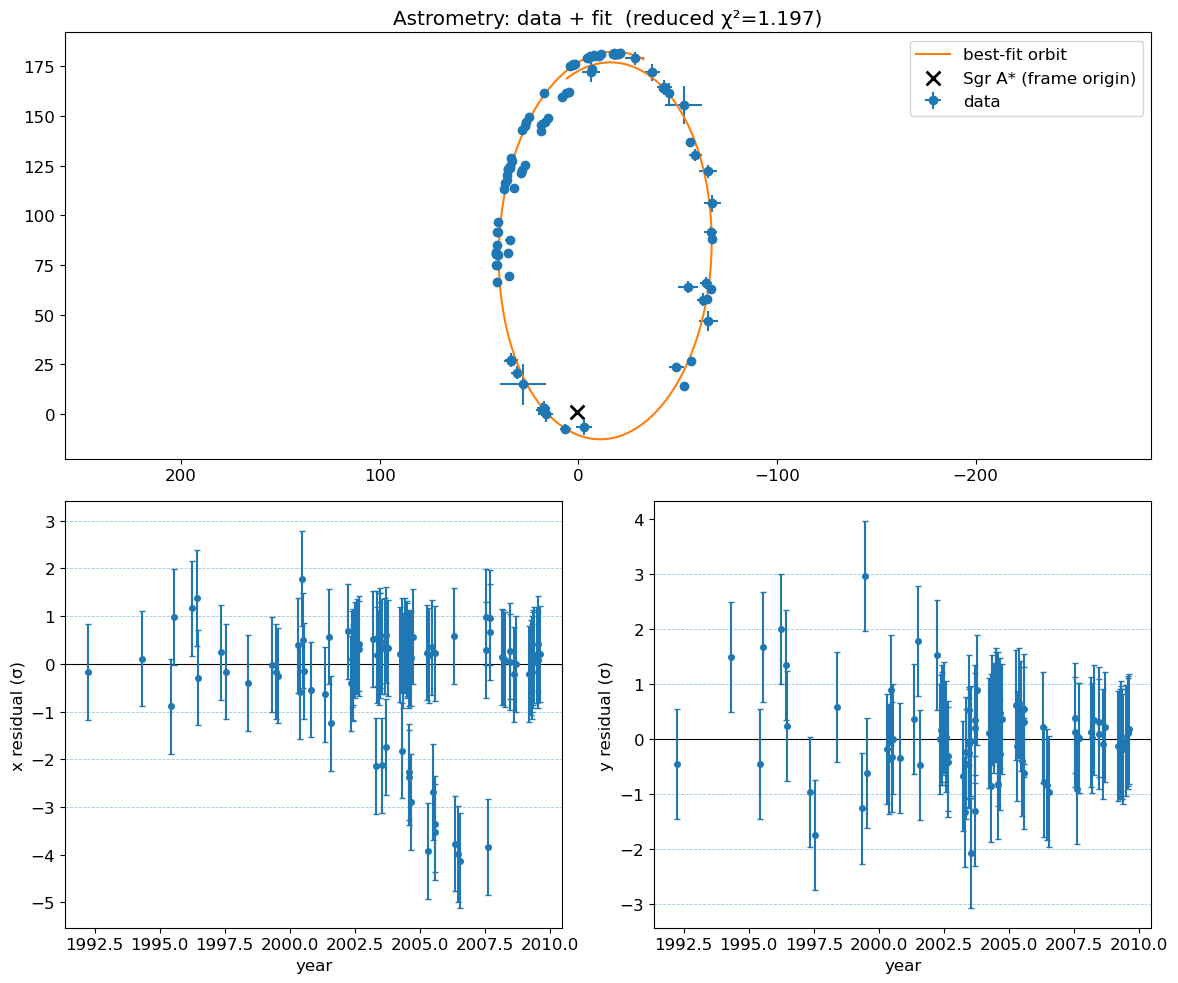

In [10]:
def compute_chi2_and_plots(df, popt):
    """
    Astrometry-only chi^2 + plots (R0 fixed externally).
    popt indices:
      0..6  : a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year
      7..10 : x0_mas, y0_mas, vx0_masyr, vy0_masyr
      11    : log_s_xy
    """
    # unpack
    a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year = popt[:7]
    x0, y0, vx0, vy0 = popt[7], popt[8], popt[9], popt[10]
    log_s_xy = popt[11]
    s_xy = np.exp(log_s_xy)

    # data
    t = df['year'].values
    xobs = df['x_mas'].values
    yobs = df['y_mas'].values
    xerr = df['x_err_mas'].values
    yerr = df['y_err_mas'].values

    # model
    xmod, ymod, _, _ = orb_elements_to_sky(
        t, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0_mas=x0, y0_mas=y0, vx0_masyr=vx0, vy0_masyr=vy0
    )

    # chi^2
    denom_x = np.sqrt(xerr**2 + s_xy**2)
    denom_y = np.sqrt(yerr**2 + s_xy**2)
    chi2_ast = np.sum(((xobs - xmod)/denom_x)**2 + ((yobs - ymod)/denom_y)**2)
    N_ast = 2 * len(t)
    N_params = len(popt)
    dof = N_ast - N_params
    red = chi2_ast / max(dof, 1)

    print(f"Global chi2 = {chi2_ast:.2f}, dof = {dof}, reduced chi^2 = {red:.3f}")
    print(f"  Jitter: s_xy = {s_xy:.3f} mas  |  R0 (fixed) = {R0_FIXED_KPC:.3f} kpc")

    # -------- Plots --------
    # Orbit on sky
    plt.figure(figsize=(12, 10))
    plt.subplot(211)
    plt.errorbar(xobs, yobs, xerr=xerr, yerr=yerr, fmt='o', label='data')
    t_fine = np.linspace(t.min() - 1, t.max() + 1, 1000)
    xfit, yfit, _, _ = orb_elements_to_sky(
        t_fine, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0_mas=x0, y0_mas=y0, vx0_masyr=vx0, vy0_masyr=vy0
    )
    plt.plot(xfit, yfit, '-', label='best-fit orbit')
    plt.scatter([x0], [y0], marker='x', color='k', s=100, linewidths=2, label='Sgr A* (frame origin)')
    plt.gca().invert_xaxis()
    plt.axis('equal')
    plt.legend()
    plt.title(f'Astrometry: data + fit  (reduced χ²={red:.3f})')

    # -------- Normalized residuals (σ units) --------
    rx = (xobs - xmod) / denom_x
    ry = (yobs - ymod) / denom_y

    plt.subplot(223)
    plt.axhline(0, color='k', linewidth=0.8)
    for k in (1, 2, 3, -1, -2, -3):
        plt.axhline(k, linestyle='--', linewidth=0.6, alpha=0.4)
    plt.errorbar(df['year'], rx, yerr=np.ones_like(rx), fmt='o', ms=4, capsize=2)
    plt.xlabel('year'); plt.ylabel('x residual (σ)')

    plt.subplot(224)
    plt.axhline(0, color='k', linewidth=0.8)
    for k in (1, 2, 3, -1, -2, -3):
        plt.axhline(k, linestyle='--', linewidth=0.6, alpha=0.4)
    plt.errorbar(df['year'], ry, yerr=np.ones_like(ry), fmt='o', ms=4, capsize=2)
    plt.xlabel('year'); plt.ylabel('y residual (σ)')

    plt.tight_layout()
    plt.show()

# call as before:
compute_chi2_and_plots(df, popt)



## Conclusion

Using astrometry data for S2, we fit a full Keplerian orbit with frame offsets, linear drift, and astrometric jitter. Because sky-plane angles do not constrain the physical distance, we applied a Gaussian prior on the Galactic Center distance $(R_0 = 8.0 )$ kpc to regularize the fit. The model converged to $(a = 125.4)$ mas and $(P = 16.13)$ yr, giving a physical semimajor axis of $(1028)$ AU and a black hole mass of $((4.18 \pm\ 0.78)\times10^6\,M_\odot)$, consistent with published values. A full determination of $(R_0)$ and mass of Sgr A* without priors would require incorporating radial velocity data.


## Reflection

As we worked through this analysis, we gained a clearer understanding of how the orbit-fitting process responds to parameters like $(R_0)$, the semi-major axis, and the jitter term. Evaluating the chi-squared and examining the residuals gave us a better sense of where the model aligns well with the data and where small discrepancies persist. Translating the angular semi-major axis into physical units also helped us appreciate how_
We found that we had to make various adjustments to the code in order to make sure all the data was accurate, but this project was particurly interesting, as Dr. Ghez visited Ohio State, so it was fun to be able to get a glipse into her work on a deeper level!

## Interesting Failures Encountered
- While searching for RV tables using Astroquery, it ran for MINUTES and was never able to extract the data. Due to this, we had to make R0 a fixed constant because it is not possible to break the angular–physical degeneracy using astrometry alone.
- While starting the project, since you need internet to be able to use Astroquery, we tried to make synthetic data that the user can fall back on if they are offline, but the data was very poor and was difficult to improve.

## Contribution Statement

Allison Trusko:

- Markdowns
- Astroquerying the S2 orbital data
- Code cleanup
- Debugging
- Fixing $\chi^2_{\rm red}$ to be closer to 1
- README.md file

Eling Cheng:

- Markdowns
- Making the GitHub
- Code cleanup
- Debugging
- requirements.txt file
- README.md file